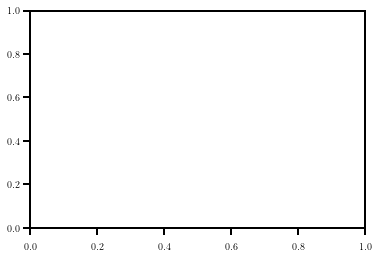

In [1]:
import os
import sys
sys.path.append("/mnt/scratch/henrypurcell/N3AS/Emu_scripts/data_reduction")
import yt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
from scipy import optimize as opt
import h5py
import amrex_plot_tools as amrex
import emu_yt_module as emu
import spin_flip_tools as sft
import glob
import concurrent
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator,LogLocator)
from matplotlib import cm, colors
import matplotlib.axes as ax
from mpl_toolkits.mplot3d import Axes3D
import latex
from itertools import product

# For ease of development, reload the relevant modules to make sure they are up to date.
import importlib
importlib.reload(sft)

c = 299792458 #m/s
hbar =6.582119569E-16 #eV s
G=1.1663787E-23 # eV^-2 (fermi constant)
M_p=1.6726219*10**(-24)#grams (Proton mass)

################
# plot options #
################
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.family'] = 'serif'
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rc('text', usetex=True)
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.grid'] = False
plt.show()
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'
f,ax=plt.subplots()
def sin(theta):
    return np.sin(theta)
def cos(theta):
    return np.cos(theta)
def exp(x):
    return np.exp(x)
pi=np.pi

In [2]:
def gellmann(j, k, d):
    r"""Returns a generalized Gell-Mann matrix of dimension d. According to the
    convention in *Bloch Vectors for Qubits* by Bertlmann and Krammer (2008),
    returns :math:`\Lambda^j` for :math:`1\leq j=k\leq d-1`,
    :math:`\Lambda^{kj}_s` for :math:`1\leq k<j\leq d`,
    :math:`\Lambda^{jk}_a` for :math:`1\leq j<k\leq d`, and
    :math:`I` for :math:`j=k=d`.

    :param j: First index for generalized Gell-Mann matrix
    :type j:  positive integer
    :param k: Second index for generalized Gell-Mann matrix
    :type k:  positive integer
    :param d: Dimension of the generalized Gell-Mann matrix
    :type d:  positive integer
    :returns: A genereralized Gell-Mann matrix.
    :rtype:   numpy.array

    """

    if j > k:
        gjkd = np.zeros((d, d), dtype=np.complex128)
        gjkd[j - 1][k - 1] = 1
        gjkd[k - 1][j - 1] = 1
    elif k > j:
        gjkd = np.zeros((d, d), dtype=np.complex128)
        gjkd[j - 1][k - 1] = -1.j
        gjkd[k - 1][j - 1] = 1.j
    elif j == k and j < d:
        gjkd = np.sqrt(2/(j*(j + 1)))*np.diag([1 + 0.j if n <= j
                                               else (-j + 0.j if n == (j + 1)
                                                     else 0 + 0.j)
                                               for n in range(1, d + 1)])
    else:
        gjkd = np.diag([1 + 0.j for n in range(1, d + 1)])

    return gjkd


def get_GM(d):
    r'''Return a basis of orthogonal Hermitian operators on a Hilbert space of
    dimension d, with the identity element in the last place.

    '''
    return np.array([gellmann(j, k, d) for j, k in product(range(1, d + 1), repeat=2)])

# finds Gell Mann projection vector of a matrix
def GM_projection(M):
    matrix_size = np.shape(M)[0]
    GM_components = get_GM(matrix_size)
    return np.array([np.trace(0.5*GM_components[n] @ M) for n in np.arange(0, matrix_size**2-1)])

#scalar magnitude of GM projection
def GM_magnitude(M):
    return np.linalg.norm(GM_projection(M))

#magnitude of array by just squaring and adding all components. this is equivalent to the above if you're looking at an off-diagonal subset of an array (eg HLR).
def sum_magnitude(M):
    size=M.shape[0]
    M_flattened = M.reshape(size**2)
    return np.linalg.norm(M_flattened)

#returns H dot P as Gell Mann projection vectors. Resonance occurs when this is 0 
def GM_dotprod(H, P):
    if np.shape(H)[0] != np.shape(P)[0]:
        raise TypeError('H and P have different dimensions')
        return
    else: 
        return np.dot(np.real(GM_projection(H)),np.real(GM_projection(P)))
    
#takes in value that depends on theta, phi and returns a theta_res by phi_res array of values 
def angularArray(func, theta_res, phi_res):   
    return np.array([[func(theta, phi) for phi in np.linspace(0, 2*pi, phi_res)]
                                      for theta in np.linspace(0, pi, theta_res)])

def rm_trace(M):
    return np.array(M) - np.trace(M)*np.identity(np.array(M).shape[0])/np.array(M).shape[0]

def visualizer(M, log=True, text=False, traceless = False, vmin=1E-15,vmax=1E-6):
    if traceless ==True:
        M=rm_trace(M)
    else:
        M=np.array(M)
    
    matrix_size = M.shape[0]
    grid_subdivisions = 1/matrix_size
    vertices_x = [n*grid_subdivisions for n in np.arange(0,matrix_size+1)]
    vertices_y = [n*grid_subdivisions for n in np.arange(matrix_size,-1,-1)]
    
    min_value=vmin
    max_value=vmax
    
    if log ==True: scale = norm=colors.LogNorm(vmin=min_value, vmax=max_value)
    else: scale = None
    
    
    f, ax = plt.subplots()
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    
    image = ax.pcolormesh(vertices_x,vertices_y,np.abs(M),cmap='hot',norm=scale)
    plt.colorbar(image)
    
    if text=='mag':
        for n in np.arange(0,matrix_size):
            for m in np.arange(0,matrix_size):
                xcoord = (n+1/6)*grid_subdivisions
                ycoord = 1 - (m+1/2)*grid_subdivisions
                ax.text(xcoord, ycoord, str(round(np.log10(np.abs(M[m,n])),0)), color='cyan', size=10)
                
    elif text=='arg':
        for n in np.arange(0,matrix_size):
            for m in np.arange(0,matrix_size):
                xcoord = (n)*grid_subdivisions
                ycoord = 1 - (m+1/2)*grid_subdivisions
                ax.text(xcoord, ycoord, str(round(np.real(M[m,n]/np.abs(M[m,n])), ndigits=1))+'+'+str(round(np.imag(M[m,n])/np.abs(M[m,n]), ndigits=2))+'i', color='cyan', size=9)

[ 6.58211957e-16 -6.58211957e-16             inf             inf
             inf             inf]
[ 6.58211957e-16 -6.58211957e-16             inf             inf]
[ 6.58211957e-16 -6.58211957e-16]


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_2984715/1144532980.py:72: RuntimeWarning: divide by zero encountered in true_divide
  print(hbar/np.real(np.linalg.eig(self.H)[0]))
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_2984715/1144532980.py:72: RuntimeWarning: divide by zero encountered in true_divide
  print(hbar/np.real(np.linalg.eig(self.H)[0]))
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


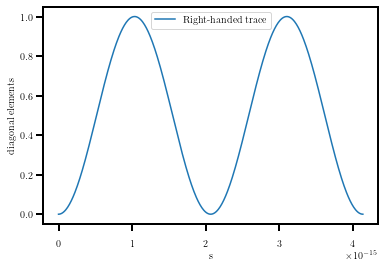

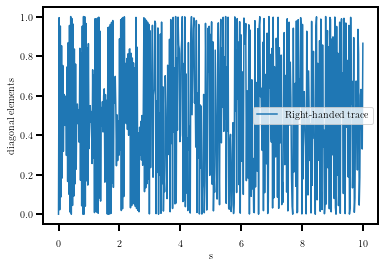

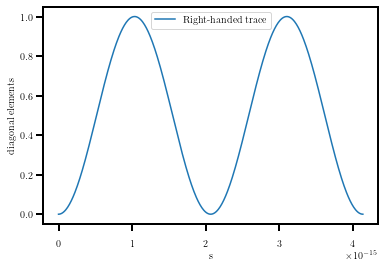

In [3]:
class Diagonalizer:
    def __init__(self, H):            
        #get Hamiltonian (use units eV)
        self.H = H
        self.Hsize = self.H.shape[1]
        
        #list of eigenvalues 
        self.eigenvals = (1+0*1j)*np.real(np.linalg.eig(self.H)[0] )

        #(inverted) array of normalized eigenvectors
        #a.k.a. change of basis matrix from Energy to flavor/spin
        #ket_f = f_to_e(ket_e)
        #H_f = (f_to_e) H_diag (e_to f)^-1
        self.f_to_e = (1+0*1j)*np.linalg.inv(np.linalg.eig(self.H)[1]) 
        
        self.H_diag = self.f_to_e @ self.H @ np.linalg.inv(self.f_to_e)
    #Time evolution operator in energy basis
    def U_energy(self, t):
        return np.diag([exp(-1j*eigenvalue*t/hbar) for eigenvalue in self.eigenvals])
   
    def U_flavor(self, t):
        return np.linalg.inv(self.f_to_e) @ self.U_energy(t) @ self.f_to_e
   
    #time array of neutrino density matrix, with init_array as intial condition
    def state_evolution(self, resolution, t_lim, init_array):
        return np.array([self.U_flavor(t) @ init_array @ np.linalg.inv(self.U_flavor(t)) for t in np.linspace(0, t_lim, resolution)])
    
    def timescales(self, minmax = True):
        eigenvals = np.real(np.linalg.eig(self.H)[0])
        differences = np.array([[abs(eig1 - eig2) 
                                 for eig1 in eigenvals  if eig2 != eig1] 
                                for eig2 in eigenvals]
                              ).flatten()
        if minmax == True:
            print('Minimum Timescale: '+str(hbar/max(differences))+' s')
            print('Maximum Timescale: '+str(hbar/min(differences))+' s')
        else:
            return hbar/differences
        
    def state_evolution_plotter(self, t_lim, resolution=500, quantity = 'state_right', ylim = None, init_array = np.diag((1,0,0,0,0,0)), savefig = False):
        flavornum = self.Hsize//2
        #s_vs_t.shape = t,2nf,2nf
        state_vs_time = self.state_evolution(resolution, t_lim, init_array)
        
        state_left = np.trace(state_vs_time[:,0:flavornum,0:flavornum], axis1= 1, axis2 = 2)
        state_right = np.trace(state_vs_time[:,flavornum:2*flavornum,flavornum:2*flavornum], axis1= 1, axis2 = 2)
        left_minus_right = state_left - state_right
        
        nth_diagonal = np.array([state_vs_time[:,n,n] for n in np.arange(0,2*flavornum)])
        
       
        f, ax = plt.subplots()
        ax.set_ylabel('diagonal elements')
        ax.set_xlabel('s')
        
        if ylim != None:
            ax.set_ylim(0,ylim)
        
        
        if type(quantity) == type([]):
            for n in quantity:
                ax.plot(np.linspace(0,t_lim,resolution),nth_diagonal[n], label = str(n))
        elif quantity == 'state_left':
                ax.plot(np.linspace(0,t_lim,resolution),state_left, label = 'Left-handed trace')
        elif quantity == 'state_right':
                ax.plot(np.linspace(0,t_lim,resolution),state_right, label = 'Right-handed trace')
        elif quantity == 'left_minus_right':
                ax.plot(np.linspace(0,t_lim,resolution),left_minus_right, label = 'Left minus Right')

        plt.legend()
        
        print(hbar/np.real(np.linalg.eig(self.H)[0]))
        
        if savefig == True: 
            plt.tight_layout()
            plt.savefig('../evolvedstate.png', dpi=300)
    
        
        
        
        
        
        
        
Htest= np.zeros((6,6))
Htest[3,0]=1
Htest[0,3]=1

Htest_2f= np.zeros((4,4))
Htest_2f[2,0]=1
Htest_2f[0,2]=1

Diagonalizer(H = Htest).state_evolution_plotter( 2*pi*6.582119569E-16, init_array = np.diag((1,0,0,0,0,0)))
Diagonalizer(H=Htest_2f).state_evolution_plotter(1E1, init_array = np.diag((1,0,0,0)))
Diagonalizer( H= np.array([[0,1],[1,0]])).state_evolution_plotter(2*pi*6.582119569E-16, init_array = np.diag((1,0)))


#Diagonalizer(directory, simulation_t, H).state_evolution_plotter(resolution, xlim, init_arrayf)

In [21]:
#Given a spinflip dataset, finds the hamiltonian at some angle. Can also check resonant direction
#location is where to evaluate stuff like Ye, rho 
class SpinParams:
    def __init__(self, t_sim = 0, data_loc = '/mnt/scratch/henrypurcell/N3AS/data/i106_j136_k099_highres_sfm_J.h5', 
                 p_abs=10**7, location = [106,136,99], merger_data_loc = "/mnt/scratch/henrypurcell/N3AS/data/merger_grid.h5"):
        
        self.data_loc = data_loc
        self.h5file = h5py.File(self.data_loc, "r")
 
        self.p_abs = p_abs
        self.t_sim = t_sim
         
        #Grid-dependent stuff: Electron fraction, baryon n density
        self.location=location
        if location != None:   
            self.merger_grid = h5py.File(merger_data_loc, 'r')
            self.rho = np.array(self.merger_grid['rho(g|ccm)'])[location[0],location[1],location[2]] #g/cm^3 (baryon mass density)
            self.Ye = np.array(self.merger_grid['Ye'])[location[0],location[1],location[2]]
            self.n_b = self.rho/M_p*(hbar**3 * c**3)#eV^3 (baryon number density)
        else: 
            self.Ye = 0.21690808855662308
            self.rho = 50091419880.43257
            self.n_b = self.rho/M_p*(hbar**3 * c**3)
            
        #Flux (spacetime, F, F, z)
        self.J = sft.total(self.h5file, 'J(eV^3)')[self.t_sim]
       
        #length of 1d array 
        self.nz = self.J.shape[3]
        
        #neutrino part of Sigma
        self.S_R_nu = sft.sigma(self.J)[0]
        self.S_L_nu = sft.sigma(self.J)[1]
        
        #matter part of Sigma
        self.S_R_mat = np.zeros(np.shape(self.J))  
        for k in np.arange(0, self.nz):
            self.S_R_mat[0,:,:,k] = 2**(-1/2)*G*self.n_b*np.array([[3*self.Ye-1,    0,      0],
                                              [0,           self.Ye-1, 0],
                                              [0,              0,   self.Ye-1 ]])
        self.S_L_mat = (-1)*np.transpose(self.S_R_mat, axes=(0,2,1,3))   
        
        #Total Sigma
        self.S_R = self.S_R_nu + self.S_R_mat
        self.S_L = self.S_L_nu + self.S_R_mat
        
        #Mass part
        self.M = sft.M_3flavor
        self.H_vac = 1/(2*self.p_abs)*np.matmul(self.M,sft.conj(self.M))
        
        

    def S_L_kappa(self, theta, phi):
        basis = sft.Basis(theta,phi)
        return np.average(sft.kappa(self.S_L, basis), axis = 2)

    def S_R_kappa(self, theta, phi):
        basis = sft.Basis(theta,phi)
        return np.average(sft.kappa(self.S_R, basis), axis = 2)

    def H_L_pm(self, theta, phi):
        basis = sft.Basis(theta,phi)
        S_L_minus = sft.minus(self.S_L, basis)
        S_L_plus = sft.plus(self.S_L, basis)
        H_L_pm = 2./self.p_abs * np.array([np.matmul(S_L_minus[:,:,z], S_L_plus[:,:,z])
            for z in range(self.nz)]).transpose((1,2,0))
        return np.average(H_L_pm, axis=2)

    def H_R_pm(self, theta, phi):
        basis = sft.Basis(theta,phi)
        S_R_minus = sft.minus(self.S_R, basis)
        S_R_plus = sft.plus(self.S_R, basis)
        H_R_pm = 2./self.p_abs * np.array([np.matmul(S_R_plus[:,:,z], S_R_minus[:,:,z])
            for z in range(self.nz)]).transpose((1,2,0))
        return  np.average(H_R_pm, axis = 2)


    #NO DERIVATIVE TERM
    def H_L(self, theta, phi):
        basis = sft.Basis(theta,phi)
        return self.S_L_kappa(theta, phi) + self.H_vac + self.H_L_pm(theta, phi)

    def H_R(self, theta, phi):
        basis = sft.Basis(theta,phi)
        return self.S_R_kappa(theta, phi) + self.H_vac + self.H_R_pm(theta, phi)

    def H_LR(self, theta, phi):          
        basis = sft.Basis(theta, phi)
        S_L_plus = np.average(sft.plus(self.S_L, basis), axis = 2)
        S_R_plus = np.average(sft.plus(self.S_R, basis), axis = 2)
        
       # MSl = np.array([ np.matmul(conj(M),S_L_plus[:,:,n]) for n in range(nz) ])
       # SrM = np.array([ np.matmul(S_R_plus[:,:,n],conj(M))  for n in range(nz) ])
        MSl = np.array(np.matmul(sft.conj(self.M),S_L_plus))
        SrM = np.array(np.matmul(S_R_plus,sft.conj(self.M)))
        return (-1/self.p_abs)*(SrM-MSl)


    #full Hamiltonian
    def H(self, theta, phi):
        return np.concatenate((np.concatenate( (self.H_R(theta, phi), np.conjugate(self.H_LR(theta,phi).transpose(1,0))), axis=0),
                np.concatenate((self.H_LR(theta,phi), self.H_L(theta,phi)), axis = 0)), axis = 1)

    #NEED DEFINITION OF DENSITY MATRIX
    def P(self, theta, phi):
        
        return np.diag((1,0,0,0,0,0))




    def resonance_full(self, theta, phi):
        return GM_dotprod(self.H(theta,phi),self.P(theta,phi))
    
    #checks resonance condition [H_L]_f1f1 = [H_R]_f2f2
    #equals resonance from tian et al if f1=f2=0 (electron)
    def resonance_2f(self, theta, phi, f1, f2):
        return self.H(theta,phi)[f1,f1]-self.H(theta,phi)[f2,f2]

    def resonance_old(self, theta, phi):
        return np.real(2**(-1/2)*G*self.n_b*(3.*self.Ye-np.ones_like(self.Ye))+self.S_R_kappa(theta,phi)[0,0])

    def angularPlot(self, theta_res, phi_res, savefig=False, use_gm=True, direction_point=False):
            
        if use_gm==True:
            H_LR_array = np.array([[np.abs(np.trace(self.H_LR(theta, phi))) 
                                   for phi in np.linspace(0, 2*pi, phi_res)]
                                   for theta in np.linspace(0, pi, theta_res)])
        else: 
            H_LR_array = np.array([[sum_magnitude(self.H_LR(theta, phi)) 
                                   for phi in np.linspace(0, 2*pi, phi_res)]
                                   for theta in np.linspace(0, pi, theta_res)])

        
        resonance_array = np.array([[self.resonance_old(theta,phi)
                                   for phi in np.linspace(0, 2*pi, phi_res)]
                                   for theta in np.linspace(0, pi, theta_res)]) 

        f = plt.figure()
        ax = f.add_subplot(projection = 'mollweide')
        ax.grid(False)
        #ax.set_title(r'Angular plot of $H_{LR}$')
        
        H_LR_im = ax.pcolormesh(np.linspace(-np.pi, np.pi, phi_res), 
                                np.linspace(0.5*np.pi, -0.5*np.pi, theta_res),
                                H_LR_array, 
                                cmap=plt.cm.hot, shading='auto')

        plt.colorbar(H_LR_im, label="eV")

        #resonance 
        res_im = ax.contour(np.linspace(-np.pi, np.pi, phi_res),
                            np.linspace(0.5*np.pi, -0.5*np.pi, theta_res),
                           resonance_array, levels=[0.], colors='cyan', label = "Resonant Directions" )
        
        h1,l1 = res_im.legend_elements()

        #add net flux point 
        J_avg = np.array([GM_magnitude(np.average(self.J[n], axis = 2)) for n in range(0,4)])
        flux_point = ax.scatter([np.arctan2(J_avg[2],J_avg[1])],[np.arctan2(J_avg[3],
                                                (J_avg[1]**2+J_avg[2]**2)**(1/2))],  label = 'ELN Flux Direction', color='lime')
        
        #add (electron) neutrino direction point
        flow_direction = np.array(self.merger_grid['fn_a(1|ccm)'])[:,self.location[0],self.location[1],self.location[2]]
        direction_point = ax.scatter([np.arctan2(flow_direction[1],flow_direction[0])],[np.arctan2(flow_direction[2],
                                                (flow_direction[0]**2+flow_direction[1]**2)**(1/2))],  label = 'Neutrino Flow Direction', color='magenta')
        
        
        plt.legend([h1[0], flux_point, direction_point], ["Resonant Directions", "Number Flux Direction", "Polar Direction"], loc=(0, 1.13))

            
        if savefig == True: 
            plt.tight_layout()
            plt.savefig('../angularPlot.png', dpi=300)
        
         
        
    #uses scipy rootfinder to locate polar angle of resonance contour. Assumes rotational symmetry (picks phi=0)
    #Currently only works for the old resonance condition
    
    #uses scipy rootfinder to locate polar angle of resonance contour. Assumes rotational symmetry (picks phi=0)
    #Currently only works for the old resonance condition
    
    def J_avg(self): 
        return np.array([sum_magnitude(np.average(self.J[n], axis = 2)) for n in range(0,4)])
    
    def resonant_theta(self, phi=0):
        res_function = self.resonance_old
        return opt.bisect(res_function,0,pi,args = (phi))
    
    #resonant Hamiltionian at azimuthal angle phi (should be independent of phi)
    def resonant_Hamiltonian(self, phi=0):
        theta = self.resonant_theta(phi)
        return self.H(theta,phi)
    
    def H_array(self):
        return np.array([[sum_magnitude(self.H_LR(theta, phi)) 
                                   for phi in np.linspace(0, 2*pi, 50)]
                                   for theta in np.linspace(0, pi, 50)])
    

/tmp/ipykernel_2984715/3192274609.py:152: UserWarning: No contour levels were found within the data range.
  res_im = ax.contour(np.linspace(-np.pi, np.pi, phi_res),
/tmp/ipykernel_2984715/3192274609.py:152: UserWarning: The following kwargs were not used by contour: 'label'
  res_im = ax.contour(np.linspace(-np.pi, np.pi, phi_res),


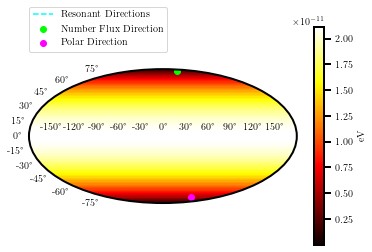

In [22]:
SpinParams(t_sim = 100).angularPlot(100,100)

In [5]:
class TimePlots:
    def __init__(self, data_loc = '/mnt/scratch/henrypurcell/N3AS/data/i106_j136_k099_highres_sfm_J.h5', 
           p_abs=10**7, location = [106,136,99], merger_data_loc = "/home/henryrpg/Desktop/N3AS/data/merger_grid.h5"):
        
        self.precision = 1
        
        self.data_loc = data_loc
        self.h5file = h5py.File(self.data_loc, "r")
 
        self.time_axis = np.array(self.h5file["t(s)"])*1E9 #ns
        self.nt = self.time_axis.shape[0]-10
    
        self.spin_params_timearray = [SpinParams(t_sim= t, data_loc=data_loc, p_abs=p_abs, location=location, merger_data_loc=merger_data_loc) for t in np.arange(0,self.nt,self.precision)]
        
    #(spacetime, F, F, z)
    def J_spatial_flavoravg(self, avg_method = 'GM'): 
        if avg_method == 'GM':
            return np.array([[GM_magnitude(np.average(SPclass.J[n], axis = 2)) 
                              for n in range(1,4)] for SPclass in self.spin_params_timearray])
        elif avg_method == 'sum':
            return np.array([[sum_magnitude(np.average(SPclass.J[n], axis = 2)) 
                              for n in range(1,4)] for SPclass in self.spin_params_timearray])

    def J_time_flavoravg(self, avg_method = 'GM'): 
        if avg_method == 'GM':
            return np.array([GM_magnitude(np.average(SPclass.J[0], axis = 2)) 
                               for SPclass in self.spin_params_timearray])
        elif avg_method == 'sum':
            return np.array([sum_magnitude(np.average(SPclass.J[0], axis = 2)) 
                              for SPclass in self.spin_params_timearray])
        
    def H_LR(self, avg_method, theta, phi):
        if avg_method == 'GM':
            return np.array([GM_magnitude(SPclass.H_LR(theta,phi)) 
                               for SPclass in self.spin_params_timearray])
        elif avg_method == 'sum':
            return np.array([sum_magnitude(SPclass.H_LR(theta,phi)) 
                               for SPclass in self.spin_params_timearray])
        

    def plot(self, quantity, avg_method = 'GM', theta=0, phi=0, set_title = None, savefig = False):

        direction = [cos(phi)*sin(theta),sin(phi)*sin(theta),cos(theta)]
        f, ax = plt.subplots()

        if quantity == 'J_spatial': 
            J = self.J_spatial_flavoravg(avg_method)
            J_directional_projection = np.array([np.dot(J_at_t,direction) for J_at_t in J])
            plt.semilogy(np.arange(0,self.nt,self.precision),J_directional_projection)
            ax.set_ylabel(r"$eV^3$")
            ax.set_title(r'Directional Component of $J_\mu$ vs time')

        elif quantity == 'J_time': 
            J = self.J_time_flavoravg(avg_method)
            J_directional_projection = np.array([np.dot(J_at_t,direction) for J_at_t in J])
            plt.semilogy(np.arange(0,self.nt,self.precision),J_directional_projection)
            ax.set_ylabel(r"$eV^3$")
            ax.set_title(r'Time Component of $J_\mu$ vs time')

            
        elif quantity == 'H_LR':
            H_LR=self.H_LR(avg_method, theta, phi)
            plt.semilogy(np.arange(0,self.nt,self.precision),H_LR)            
            ax.set_ylabel(r"$|H_{LR}| \ \ (eV)$")
            ax.set_title(r'$|H_{LR}|$ vs time')


            #NOT ADAPTED THESE YET
  #      elif quantity == 'H_LR_00':
  #          H_LR=sft.total(readdata,"H_LR(eV)")
  #          ax.set_ylabel(r"$|H_{LR}| \ \ (eV)$")
  #          plt.semilogy(t_axis*1E9,np.average(H_LR[:,0,0,:], axis=1), label = 'electron component')
  #          plt.semilogy(t_axis*1E9,np.average(H_LR[:,1,1,:], axis=1), label = 'muon component')
  #          plt.semilogy(t_axis*1E9,np.average(H_LR[:,2,2,:], axis=1), label = 'tau component')
  #          ax.legend()
  #          ax.set_ylim(1E-25,1E-15)
            
  #      elif  quantity == 'kappa':
  #          kappa=sft.total(data,'S_R_kappa(eV)')
  #          ax.set_ylabel(r"$eV$")
  #         plt.plot(t*1E9,np.average(kappa[:,0,0,:], axis=1))

  
        ax.set_xlabel("time (ns)")
        mpl.pyplot.tick_params(axis='both',which="both", direction="in",top=True,right=True)
        mpl.pyplot.minorticks_on()


        if savefig == True: 
            plt.tight_layout()
            plt.savefig('../'+quantity+'.png', dpi=300)

        else: pass


In [38]:
class Multipoint:
    def __init__(self, i, j, k, sfm_file = '/mnt/scratch/henrypurcell/N3AS/data/sfm/', append = '_sfm_JJ',
                xmin = 75, xmax  =80, ymin=68, ymax = 73):
        self.sfm_file = sfm_file
        self.filelist = glob.glob(self.sfm_file + "/i*j*k*.h5")
        
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        
        self.i = i
        self.j = j
        self.k = k
        self.chosenfile = self.sfm_file + '/i' + f"{i:03d}" + "_j" + f"{j:03d}" + "_k" + f"{k:03d}" + append + ".h5"
        
        self.MG = Merger_Grid(zval = 96)
        
    def angularPlot(self, t):
        SP = SpinParams(t_sim = t, data_loc = self.chosenfile, location = [self.i,self.j,self.k])
        SP.angularPlot( theta_res = 100, phi_res = 100, use_gm=True, direction_point=False)
    def pointPlots(self, t, plot_tlim):
        self.MG.contour_plot(x = self.i, y = self.j, xmin = self.xmin, xmax = self.xmax, ymin = self.ymin, ymax = self.ymax)
        SP = SpinParams(t_sim = t, data_loc = self.chosenfile, location = [self.i,self.j,self.k])
        SP.angularPlot( theta_res = 50, phi_res = 50, use_gm=True, direction_point=False)
        H_resonant = SP.resonant_Hamiltonian()
        D = Diagonalizer(H_resonant)

        D.state_evolution_plotter(plot_tlim, init_array = np.diag((1,0,0,0,0,0)))
        visualizer(H_resonant)

        
            
        

/tmp/ipykernel_2984715/3192274609.py:152: UserWarning: The following kwargs were not used by contour: 'label'
  res_im = ax.contour(np.linspace(-np.pi, np.pi, phi_res),
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[-8.80343145e-10  2.83347307e-10 -1.45623813e-10 -1.45587833e-10
 -2.20534922e-10 -2.20452402e-10]


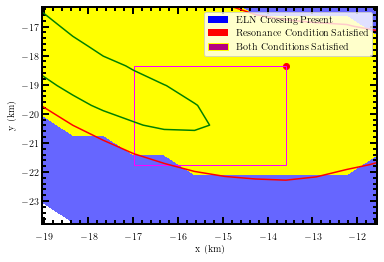

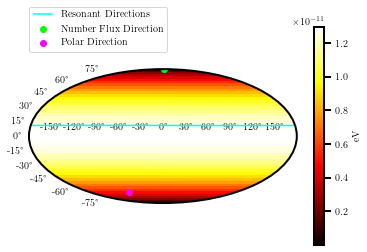

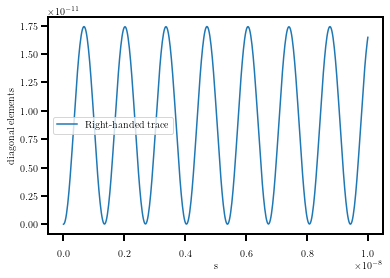

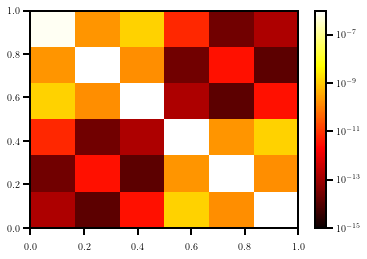

In [39]:
Multipoint(80,73,99).pointPlots(0,1E-8)

In [8]:
G=1.1663787*10**(-23) # eV^-2
c=2.998e+10 #cm/s
M_p=1.6726219*10**(-24)#grams (Proton mass)
hbar=6.58211951*10**(-16) #eV s

class Merger_Grid:
    def __init__(self, zval, data_loc = "/mnt/scratch/henrypurcell/N3AS/data/merger_grid.h5", 
                unrotated_data_loc = "/mnt/scratch/henrypurcell/N3AS/data/merger_grid_unrotated.h5",
                p_abs=10**7, theta=0, phi=0,
                rotate = True):
        
        self.zval = zval
            
        #rotated data has ELN flux along z
        if rotate == True:
            self.merger_grid = h5py.File(data_loc, 'r')
        elif rotated == False:
            self.merger_grid = h5py.File(unrotated_data_loc, 'r')
        else:
            raise TypeError('rotate = True or False')
        
        #Electron fraction, baryon n density
        self.rho=np.array(self.merger_grid['rho(g|ccm)'])[:,:,self.zval] #g/cm^3 (baryon mass density)
        self.Ye=np.array(self.merger_grid['Ye'])[:,:,self.zval]
        self.n_b=self.rho/M_p*(hbar**3 * c**3)#eV^3 (baryon number density)

        #x,y axes
        self.x_km = np.array(self.merger_grid['x(km)'])[0][:,:,0]
        self.y_km = np.array(self.merger_grid['y(km)'])[0][:,:,0]
       
        
        #basis
        self.basis = sft.Basis(theta,phi)
        #momentum
        self.p_abs = p_abs
        
        #discriminant condition
        self.discriminant = np.array(self.merger_grid['crossing_descriminant'])[:,:,self.zval]
        self.positive = np.where(self.discriminant>=0)
        self.negative = np.where(self.discriminant<0)
        self.discriminant_sign=np.zeros_like(self.discriminant)
        
        #positive areas have ELN crossings
        self.discriminant_sign[self.positive] = 1
        self.discriminant_sign[self.negative] = 0
        
        self.J_e = (hbar**3 * c**3)*(np.array([self.merger_grid['n_e(1|ccm)'],
                                             self.merger_grid['fn_e(1|ccm)'][0],
                                             self.merger_grid['fn_e(1|ccm)'][1],
                                             self.merger_grid['fn_e(1|ccm)'][2]]))[:,:,:,self.zval]
                      
        self.J_a = (hbar**3 * c**3)*np.array([self.merger_grid['n_a(1|ccm)'],
                                              self.merger_grid['fn_a(1|ccm)'][0],
                                              self.merger_grid['fn_a(1|ccm)'][1],
                                              self.merger_grid['fn_a(1|ccm)'][2]])[:,:,:,self.zval]
        
        #technically just the ee component of J
        self.J = self.J_e - self.J_a
        
        #max, min values of the LHS of the resonance condition (ADD OTHER PARTS)
        self.mag_F=np.sqrt(np.sum(self.J[1:4,:,:]**2, axis=0))
        self.H_vv_min = 2**(1./2.)*G*(self.J[0]+self.mag_F)
        self.H_vv_max = 2**(1./2.)*G*(self.J[0]-self.mag_F)
        #min occurs when flux is along basis direction
        self.resonance_val_min = 2**(-1/2)*G*self.n_b*(3.*self.Ye-np.ones_like(self.Ye))+self.H_vv_max
        self.resonance_val_max = 2**(-1/2)*G*self.n_b*(3.*self.Ye-np.ones_like(self.Ye))+self.H_vv_min

        #conditions
        #max res >0 so could be 0 for some direction
        self.positive_resonance = np.where(self.resonance_val_max>=0)
        self.pos_resonance_sign=np.zeros_like(self.discriminant)
        self.pos_resonance_sign[self.positive_resonance]=1
        #min res <0 so could be 0 for some direction
        self.negative_resonance = np.where(self.resonance_val_min<=0)
        self.neg_resonance_sign=np.zeros_like(self.discriminant)
        self.neg_resonance_sign[self.positive_resonance]=1
        
        #both must be true for resonance to exist
        self.resonance_sign = self.neg_resonance_sign*self.pos_resonance_sign
        
        #resonance and discriminant satisfied for some direction
        self.both_conditions=self.resonance_sign*self.discriminant_sign
    
        #self.res_along_J = np.where(self.resonance_val_max>=0)
        
    #Basis dependent stuff
    #returns the value of the resonance condition with the given basis at level zval
    def resonance_val(self, basis):
        S_R = 2**(1./2.)*G*np.transpose(np.array([[2*self.J,np.zeros_like(self.J)],[np.zeros_like(self.J),self.J]]),(2,0,1,3,4))
        S_R_kappa = sft.kappa(S_R,basis)

        return np.array(2**(-1/2)*G*self.n_b*(3.*self.Ye-np.ones_like(self.Ye))+S_R_kappa[0,0])

    #gets the gradient (has to get data for z+1 and z-1 too)
    def grad_magnitude(self, basis):
        J_e = (hbar**3 * c**3)*(np.array([self.merger_grid['n_e(1|ccm)'],
                                             self.merger_grid['fn_e(1|ccm)'][0],
                                             self.merger_grid['fn_e(1|ccm)'][1],
                                             self.merger_grid['fn_e(1|ccm)'][2]]))[:,:,:,(self.zval-1):(self.zval+1)]
                      
        J_a = (hbar**3 * c**3)*np.array([self.merger_grid['n_a(1|ccm)'],
                                              self.merger_grid['fn_a(1|ccm)'][0],
                                              self.merger_grid['fn_a(1|ccm)'][1],
                                              self.merger_grid['fn_a(1|ccm)'][2]])[:,:,:,(self.zval-1):(self.zval+1)]
        
        #technically just the ee component of J
        J = J_e - J_a
        
        S_R = 2**(1./2.)*G*np.transpose(np.array([[2*J,np.zeros_like(J)],[np.zeros_like(J),J]]),(2,0,1,3,4,5))
        S_R_kappa = sft.kappa(S_R,basis)
        
        resonance = np.array(2**(-1/2)*G*self.n_b[:,:,np.newaxis]*(3.*self.Ye[:,:,np.newaxis]-np.ones_like(self.Ye[:,:,np.newaxis]))+S_R_kappa[0,0])

        grad=np.gradient(resonance, 0.67928832684*1e5/(c*hbar))
        projection=np.sum(basis.n_vector[1:4,np.newaxis,np.newaxis,np.newaxis]*grad, axis=0)

        return np.array(np.abs(projection))[:,:,1]

    #gets H_LR
    def H_LRf(self, basis):
        M=sft.M_2flavor
        
        S_R = 2**(1./2.)*G*np.transpose(np.array([[2*self.J,np.zeros_like(self.J)],
                                                  [np.zeros_like(self.J),self.J]]),(2,0,1,3,4))
        S_L = -2**(1./2.)*G*np.transpose(np.array([[2*self.J,np.zeros_like(self.J)],
                                                   [np.zeros_like(self.J),self.J]]),(2,1,0,3,4))
        S_L_minus = sft.minus(S_L, basis)
        S_R_plus = sft.plus(S_R, basis)

        MSl = np.transpose(np.array([[ np.matmul(np.conj(M),S_L_minus[:,:,x,y]) 
                                                                                   for y in range(201)]
                                                                                   for x in range(201)]),(2,3,0,1))
        
        SrM = np.transpose(np.array([[ np.matmul(S_R_plus[:,:,x,y],np.conj(M))  
                                                                                   for y in range(201)]
                                                                                   for x in range(201)]) ,(2,3,0,1))
        return (-1/self.p_abs)*(SrM-MSl)
    
    #gets full H
    def H(self, basis):
        return
    #gets gamma
    def adiabaticity(self, basis):
        return np.real((self.H_LRf(basis)[0,0]**2)/self.grad_magnitude(basis))


        #gets indices of points where adiab is greater than value at z
        #
    def max_adiab(self,adiab,value):
        maxvals=np.where(adiab>value)
        coordlist=[]
        for n in range(0,len(maxvals[1])):
            coordlist.append([int(maxvals[0][n]),int(maxvals[1][n])])
        return np.array(coordlist)

    #gets the coordinates of the points of adiab higher than value (for plotting)
    def coords(self,adiab,value):
        maxpoints=self.max_adiab(adiab,value)
        xlist=[self.x_km[val[0],val[1]] for val in maxpoints]
        ylist=[self.y_km[val[0],val[1]] for val in maxpoints]
        return xlist,ylist
    
    
    def contour_plot(self, savefig = False, x = 0, y = 0, xmin = 0, xmax = 200, ymin = 0, ymax = 200):
        zval = self.zval
        
        f, ax = plt.subplots()
        
        #discriminant area
        ax.contourf(self.x_km[:,:],self.y_km[:,:], self.discriminant_sign[:,:],
                                   levels=[0.1,1,2,3], alpha=0.6, colors=['blue','red',[0.65,0,0.25]])
        
        #legend
        proxy = [plt.Rectangle((1, 1), 2, 2, fc='blue'),plt.Rectangle((1, 1), 2, 2, fc='red'),plt.Rectangle((1, 1), 2, 2, fc=[0.7,0,0.5],ec='yellow')]
        ax.legend(proxy, ["ELN Crossing Present", "Resonance Condition Satisfied","Both Conditions Satisfied"])
        
        #resonance val
        ax.contour(self.x_km[:,:],self.y_km[:,:],self.resonance_val_min[:,:], levels=[0,1], colors=['green'])
        ax.contour(self.x_km[:,:],self.y_km[:,:],self.resonance_val_max[:,:], levels=[0,1], colors=['red'])

        #both conditions
        ax.contourf(self.x_km[:,:],self.y_km[:,:],self.both_conditions[:,:], levels=[0.5,1], colors=['yellow'] )
        
        mpl.pyplot.tick_params(axis='both',which="both", direction="in",top=True,right=True)
        mpl.pyplot.minorticks_on()
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
        plt.scatter(self.x_km[x,y],self.y_km[x,y], color = 'red')
        
        ax.set_ylim(self.y_km[xmin,ymin-3],self.y_km[xmax,ymax+3])
        ax.set_xlim(self.x_km[xmin-3,ymin],self.x_km[xmax+3,ymax])
        ax.add_patch(plt.Rectangle((self.x_km[xmin,ymin],self.y_km[xmin,ymin]),self.x_km[xmax,ymax]-self.x_km[xmin,ymin],self.y_km[xmax,ymax]-self.y_km[xmin,ymin],
                             linewidth=1,edgecolor='magenta',facecolor='none'))
        #plt.contour(x[:,:,zval],y[:,:,zval],resonance_val_max[:,:,zval], levels=[0], colors=['blue'] )
        #plt.title('Resonance Conditions and ELN Crossing Regions')
        if savefig ==True:
            plt.savefig('../'+'contour_plot_'+str(zval)+'.png', dpi=300)
        else:
            pass

    #Adiabaticity Colorplot
    def adiab_plot(self, minval = 1E-5, crit_region = False, savefig = False, theta_res = pi, phi_res = 0, ):
        zval = self.zval
        adiabaticity = self.adiabaticity(self.basis)
        plt.grid(False)
        colorplot=plt.pcolormesh(self.x_km[:,:],self.y_km[:,:],np.log10(adiabaticity[:,:]),cmap=plt.cm.hot,shading='auto', vmax=-3, vmin=-10)
        
        plt.xlabel('x (km)')
        plt.ylabel('y (km)')
        plt.colorbar(label=r'$log(\gamma)$')
        
        if crit_region == True:
            contourf=plt.contourf(self.x_km[:,:],self.y_km[:,:],self.both_conditions[:,:], alpha=0.5, levels=[0.5,1], colors=['blue'] )
            proxy = [plt.Rectangle((1, 1), 2, 2, fc=pc.get_facecolor()[0]) for pc in
            contourf.collections]
        
        plt.contour(self.x_km[:,:],self.y_km[:,:],self.resonance_val(sft.Basis(theta_res,phi_res)), levels=0)
        #mpl.pyplot.tick_params(axis='both',which="both", direction="in",top=True,right=True)
        mpl.pyplot.minorticks_on()
        scatter=plt.scatter(self.coords(adiabaticity, minval)[0],self.coords(adiabaticity,minval)[1],color=[0,0.9,0], marker='x', label='Simulated Point')
        red_patch = mpatches.Patch(color=[0.3,0,0.7], label='The red data')
        plt.legend(handles=[scatter,red_patch], labels=["Simulated Point","Both Conditions Satisfied"], frameon = 1, framealpha=0.5)
        plt.tight_layout()
        plt.scatter(self.x_km[95,123],self.y_km[95,123])
        if savefig ==True:
            plt.savefig('../'+'adiabaticity_plot_'+str(zval)+'.png', dpi=300)
 

In [25]:
Merger_Grid().resonance_val_min.shape

(201, 201)

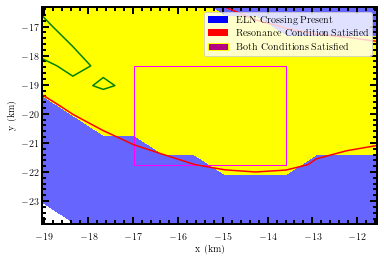

IndexError: index 203 is out of bounds for axis 1 with size 201

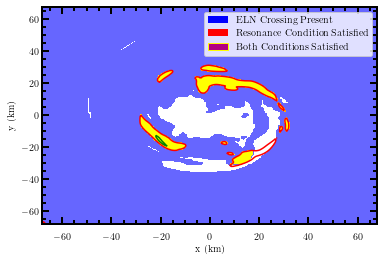

In [57]:
Merger_Grid().contour_plot()

In [10]:
res_theta = SP_0.resonant_theta(0)
HLR_res0 = SP_0.H_LR(res_theta,0)
HLR_resf = SP_100.H_LR(res_theta,0)
HLR_z0 = SP_0.H_LR(0,0)
HLR_zf = SP_100.H_LR(0,0)
HLR_x0 = SP_0.H_LR(pi/2,0)
HLR_xf = SP_100.H_LR(pi/2,0)
res_theta = SP_0.resonant_theta()
H_res0 = SP_0.H(res_theta,0)
H_resf = SP_100.H(res_theta,0)
H_z0 = SP_0.H(0,0)
H_negz0 = SP_0.H(pi,0)

H_zf = SP_100.H(0,0)
H_x0 = SP_0.H(pi/2,0)
H_xf = SP_100.H(pi/2,0)

H_d0 = SP_0.H(pi/4,0)
H_df = SP_0.H(pi/4,0)
HLR_d0 = SP_0.H_LR(pi/4,0)
HLR_df = SP_0.H_LR(pi/4,0)


In [ ]:


Diagonalizer(H = H_res0).state_evolution_plotter(1E-4, quantity = [4,5], resolution = 1500, init_array = np.diag((1,0,0,0,0,0)), savefig=True)

In [ ]:
visualizer(H_z0, vmin=1E-15,vmax=1E10, text='mag', traceless=True)

In [ ]:
hbar/1E-3

In [ ]:
H_z0_mod = H_z0
H_z0_mod[3,0] = 0
H_z0_mod[0,3] = 0

In [ ]:

class AngularPlots:
    def __init__(self, theta_res, phi_res,
                 data_loc = "/home/henryrpg/Desktop/N3AS/data/criticalpoint_spin_flip_matrices_z.h5", 
                 merger_data_loc = "/home/henryrpg/Desktop/N3AS/data/merger_grid_unrotated.h5",
                 p_abs=10**7, t_sim = 0,
                 location = None )
        
    def angular_plot(self, theta_precision = 200, phi_precision = 100, savefig = True):
        
        H_LR_angular = np.transpose((np.array([[((np.real(self.H_LR_at_basis(theta,phi)[0,0]))**2
                                               + (np.imag(self.H_LR_at_basis(theta,phi)[0,0]))**2)**(1/2)
                                            for theta in np.linspace(0,np.pi,200)] 
                                            for phi in np.linspace(0,2*np.pi,100)])))
        resonance_angular = np.transpose((np.array([[np.real(self.resonance_at_basis(theta,phi))  
                                            for theta in np.linspace(0,np.pi,200)] 
                                            for phi in np.linspace(0,2*np.pi,100)])))
        
        f = plt.figure()
        ax = f.add_subplot(projection = 'mollweide')
        ax.grid(False)
        H_LR_im = ax.pcolormesh(np.linspace(-np.pi,np.pi,phi_precision), np.linspace(-0.5*np.pi,0.5*np.pi,theta_precision),
                         H_LR_angular, 
                         cmap=plt.cm.hot, shading='auto')
        plt.colorbar(H_LR_im)
        
        res_im = ax.contour(np.linspace(-np.pi,np.pi,phi_precision), np.linspace(-0.5*np.pi,0.5*np.pi,theta_precision),
                         resonance_angular, levels=0, colors='cyan')
        
        #add net flux point 
        ax.scatter([np.arctan2(self.J[2],self.J[1])],[np.arctan2(self.J[3],
                                                (self.J[1]**2+self.J[2]**2)**(1/2))],label = 'ELN Flux Direction')
        
        #ax.scatter([np.arctan2(self.J_tot[2],self.J_tot[1])],
         #          [np.arctan2(self.J_tot[3],(self.J_tot[1]**2+self.J_tot[2]**2)**(1/2))],
          #         label = 'Main Particle Flow')
        #ax.legend()
        #ax.set_title(r'$Angular \  Plot \ of \ H_{LR}$')
        #ax.facecolor='white'
        
        #if savefig == True:
        #    plt.tight_layout()
        #    plt.savefig('../angularplot.png', dpi=300 )
        #plt.show()

In [7]:
import numpy as np

def matmul(x,y):
    vector = np.array([-4+x+2*y,7/2-2*x-3*y,x,y])
    return np.matmul(A,vector)

In [9]:
matmul(1,10)

array([ 3.,  1., -1.])

In [19]:
A=np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
b = np.array([3,1,-1])
c=np.linalg.inv(np.transpose(A)@A)
np.transpose(A)@A

array([[107, 122, 137, 152],
       [122, 140, 158, 176],
       [137, 158, 179, 200],
       [152, 176, 200, 224]])

In [12]:
help(np.invert)

Help on ufunc object:

invert = class ufunc(builtins.object)
 |  Functions that operate element by element on whole arrays.
 |  
 |  To see the documentation for a specific ufunc, use `info`.  For
 |  example, ``np.info(np.sin)``.  Because ufuncs are written in C
 |  (for speed) and linked into Python with NumPy's ufunc facility,
 |  Python's help() function finds this page whenever help() is called
 |  on a ufunc.
 |  
 |  A detailed explanation of ufuncs can be found in the docs for :ref:`ufuncs`.
 |  
 |  **Calling ufuncs:** ``op(*x[, out], where=True, **kwargs)``
 |  
 |  Apply `op` to the arguments `*x` elementwise, broadcasting the arguments.
 |  
 |  The broadcasting rules are:
 |  
 |  * Dimensions of length 1 may be prepended to either array.
 |  * Arrays may be repeated along dimensions of length 1.
 |  
 |  Parameters
 |  ----------
 |  *x : array_like
 |      Input arrays.
 |  out : ndarray, None, or tuple of ndarray and None, optional
 |      Alternate array object(s) in w

In [20]:
A=np.array([[12,16],[16,28]])
b=np.array([22,37])
np.linalg.solve(A,b)

array([0.3 , 1.15])

In [21]:
A@np.array([0.3,1.15])

array([22., 37.])

In [22]:
-4+0.3+2*1.15

-1.4000000000000004

In [23]:
7/2-2*0.3-3*1.15

-0.5499999999999998